# Baseline simulations
In this notebook, we generate single-agent interactions with the original wikipedia model.
This is done to find optimal threshold for both individual and pair-wise interactions.
We focus on identifying a threshold that yields performance close to half the total number of animals,
so to ensure the possibility of variation induced by experimental manipulations

In [54]:
import glob
from simcat.interaction import Interaction, Agent
from simcat.utils import compute_thresholds, load_matrix
from multiprocessing import Pool
import pandas as pd
import json
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import umap
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

First things first, we are starting from a pretrained vector space, and we want to do two things:
1. Make sure that the vector space is scaled, i.e., all the dimensions have the same range;
2. Compute a Euclidean distance matrix.

Let's start from the first task.

In [43]:
animals = pd.read_csv("../models/animal_list.csv")["Animals"].values.tolist()

In [44]:
vecs = pd.read_csv(
    f"../models/baseline/wiki_vectors.tsv", sep="\t", index_col=0, header=None
)
vecs_scaled = MinMaxScaler().fit_transform(vecs).round(5)
vec_df_scaled = pd.DataFrame(vecs_scaled, columns=range(vecs.shape[1]))
vec_df_scaled.index = animals
vec_df_scaled.to_csv(f"../models/baseline/wiki_vectors_scaled.tsv", sep="\t")

Now let's move on to computing Euclidean distances, and saving the resulting matrix.

In [45]:
eucl_dist = (
    euclidean_distances(vec_df_scaled.values, vec_df_scaled.values) / 400
).round(5)
eucl_dist_df = pd.DataFrame(eucl_dist)
eucl_dist_df.index = vec_df_scaled.index
eucl_dist_df.columns = eucl_dist_df.index
vec_df_scaled.to_csv(f"../models/baseline/wiki_euclidean_distance.tsv", sep="\t")

Finally, let's do one more thing. Let's store a mapping between the name of the animals and their "index" in space.
Each animal is assigned a positional index. 
This will be used later on, when we will instantiate diversity by 
swapping the position of animals in space, to keep track of the process (and to compute metrics, like originality, which 
are based on positional indices rather than words).

In [51]:
animals_idx_dict = dict(zip(animals, list(range(len(animals)))))
json.dump(animals_idx_dict, open(f"../models/baseline/wiki_mapping.json", "w"))

### Simulations
Now we can start simulating, using the Euclidean distance matrix we have computed.

In [46]:
models = ["../models/baseline/wiki_euclidean_distance.tsv"]

Let's find possible thresholds, defined as quantiles in the distribution of 
Euclidean distances in all pairs of agents.

In [47]:
thresholds = compute_thresholds(
    models, q=[round(n, 2) for n in np.arange(0.05, 1.0, 0.05)], round_at=5
)

In [48]:
print(f"thresholds: {thresholds}")

thresholds: {0.05: 0.18494, 0.1: 0.25424, 0.15: 0.30216, 0.2: 0.3391, 0.25: 0.37103, 0.3: 0.39887, 0.35: 0.42491, 0.4: 0.44973, 0.45: 0.47347, 0.5: 0.49713, 0.55: 0.52039, 0.6: 0.54485, 0.65: 0.56926, 0.7: 0.59531, 0.75: 0.62423, 0.8: 0.65581, 0.85: 0.69211, 0.9: 0.73708, 0.95: 0.80541}


Now we can start running simulations. Let's define the simulation parameters, instantiate agents, and run the interaction.

We will define a function (`run_baseline`) which we then run in parallel, over multiple processes (for speedup).

In [49]:
nr_sim = len(animals)
ID = "experiments"

In [6]:
def run_baseline(t):
    m = models[0]
    outpath = f"../logs/{ID}/baseline"
    print(f"threshold: {t}")
    m_id = m.split(".")[0].split("/")[2].split("_")[0]
    log_id = f"{m_id}"
    agent = Agent(
        agent_name="baseline",
        matrix_filename="../models/baseline/wiki_euclidean_distance.tsv",
        vector_filename="../models/baseline/wiki_vectors_scaled.tsv",
        dict_filename="../models/baseline/wiki_mapping.json",
    )
    i = Interaction(
        nr_agents=1,
        agents=agent,
        threshold=t,
        save_folder=outpath,
        log_id=log_id,
        nr_sim=nr_sim,
        kvals=[1, 3, 5],
    )
    i.run_interaction(seeds=animals)

Running the simulation with all resulting thresholds.

In [ ]:
pool = Pool(20)
pool.map(run_baseline, thresholds.values())
pool.close()

Let's now visualize the performance of the model. Let's extract the performance values.

In [ ]:
fs = glob.glob(f"../logs/{ID}/baseline/*")
for idx, f in enumerate(fs):
    df = pd.read_csv(f, index_col=0)
    print(f, df.iter.max())  # checking that all simulations have been performed
    base = df.groupby("iter").agg({"turn": "max", "threshold": "first"}).reset_index()
    base.columns = ["iter", "performance", "threshold"]
    base["threshold_q"] = base["threshold"].apply(
        lambda x: [k for k, v in thresholds.items() if x == v]
    )
    if idx == 0:
        base_agg = base.copy()
    else:
        base_agg = pd.concat([base_agg, base], ignore_index=True)

Let's now plot the performance of reference agent for each threshold.

In [8]:
base_agg["threshold_q"] = base_agg["threshold_q"].apply(lambda x: x[0])

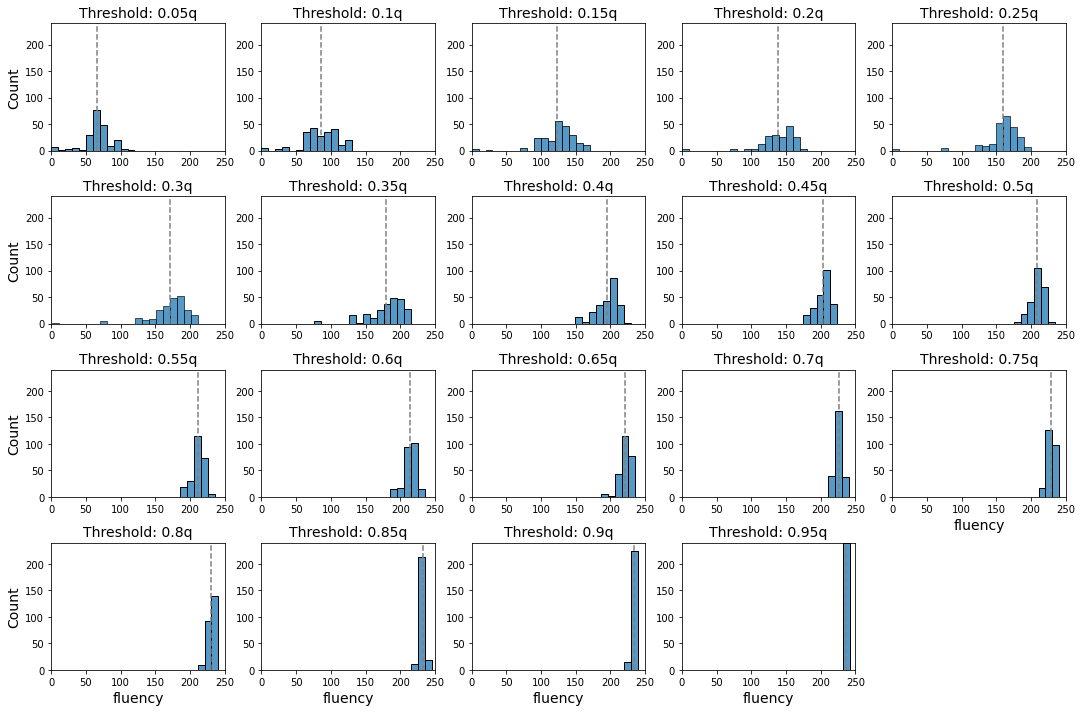

In [43]:
f, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
coords = list(itertools.product(range(4), range(5)))
thresholds = sorted(base_agg.threshold.unique().tolist())
thresholds_q = sorted(base_agg.threshold_q.unique().tolist())
for idx, c in enumerate(coords[:-1]):
    sns.histplot(
        data=base_agg[base_agg["threshold_q"] == thresholds_q[idx]],
        x="performance",
        binwidth=10,
        ax=ax[c],
    )
    ax[c].vlines(
        base_agg[base_agg["threshold_q"] == thresholds_q[idx]].performance.mean(),
        0,
        240,
        linestyle="--",
        color="grey",
    )
    ax[c].set_xlim(0, 250)
    if c[1] != 0:
        ax[c].set_ylabel("")
    else:
        ax[c].set_ylabel(ylabel="Count", fontsize=14)
    if c[0] != 3 and not (c[1] == 4 and c[0] == 2):
        ax[c].set_xlabel("")
    else:
        ax[c].set_xlabel(xlabel="fluency", fontsize=14)
    ax[c].set_ylim(0, 240)
    ax[c].set_title(f"Threshold: {thresholds_q[idx]}q", fontsize=14)
f.delaxes(ax[-1, -1])
plt.tight_layout()
plt.savefig("../figures/thresholds.png", dpi=300, bbox_inches="tight")
plt.show()

As the 0.15 quantile yields performance that is closest to half the words defined in semantic space, we will use this for all simulations.

(Let's also visualize the distribution of distances and the thresholds)

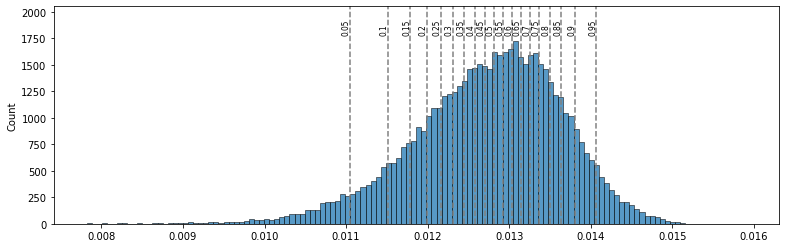

In [10]:
f, ax = plt.subplots(figsize=(13, 4))
sns.histplot(load_matrix(models[0]).values.ravel())
for idx, t in enumerate(thresholds):
    plt.axvline(t, linestyle="--", color="grey")
    plt.ylim(0, 2050)
    plt.annotate(
        thresholds_q[idx],
        xy=(t - 0.0001, 1800),
        xycoords="data",
        rotation=90,
        fontsize=7.5,
    )
plt.show()

### Visualize space through UMAP
Let's now visualize the base semantic space using a 2D reduction obtained through UMAP.
This is just to get an idea for how the initial space looks like.

Performing dimensionality reduction first.

In [34]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1)
vecs = pd.read_csv("../models/baseline/wiki_vectors_scaled.tsv", sep="\t", index_col=0)
vecs.index = animals
scaled_vecs = StandardScaler().fit_transform(vecs)
embedding = pd.DataFrame(reducer.fit_transform(scaled_vecs))

Now plotting in 2D space.

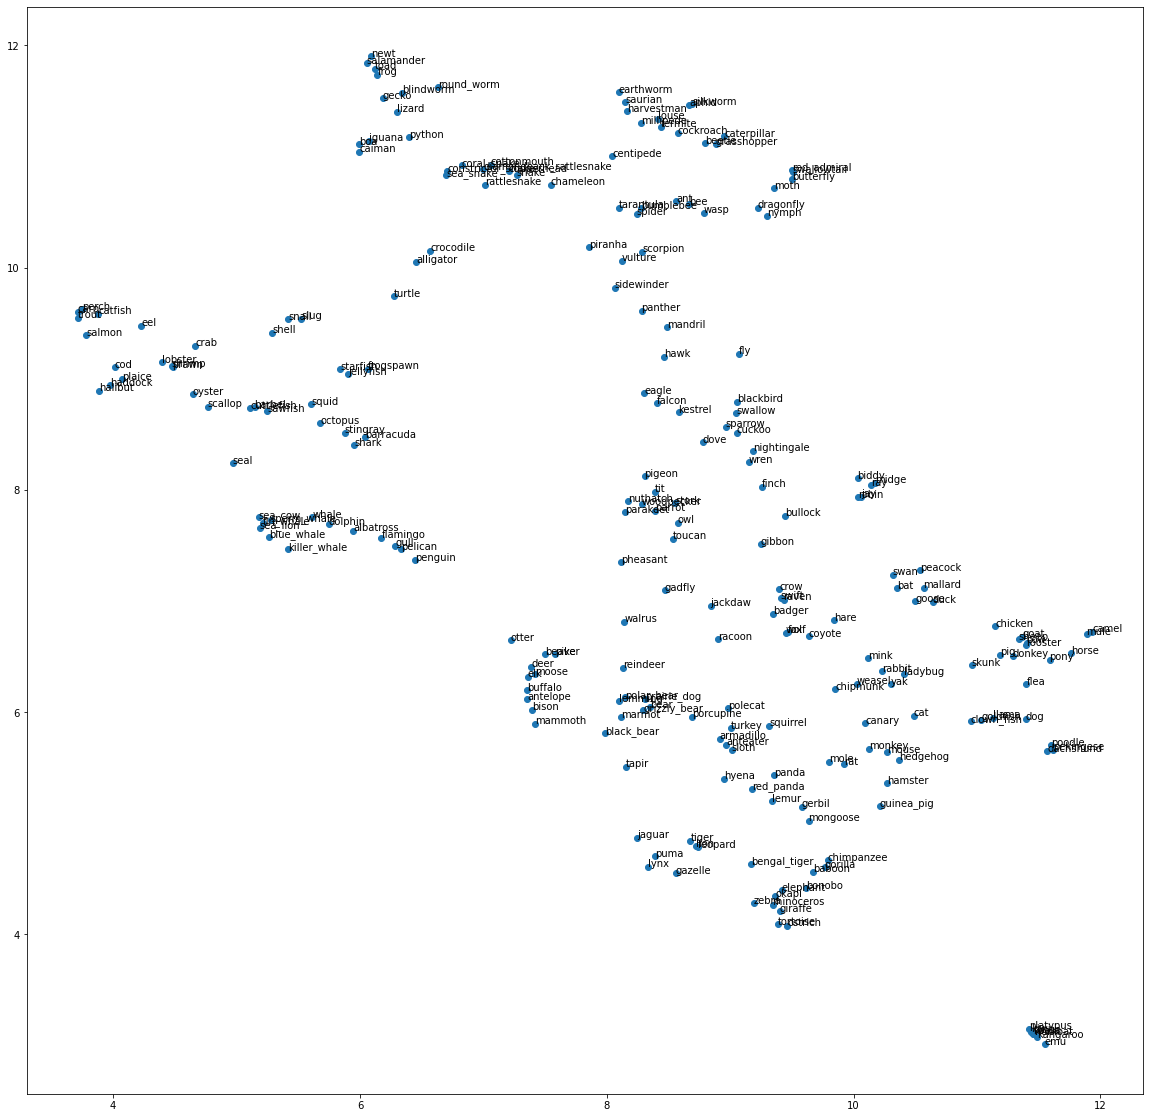

In [35]:
f, ax = plt.subplots(figsize=(20, 20))
plt.scatter(embedding.iloc[:, 0], embedding.iloc[:, 1])
for idx in range(embedding.shape[0]):
    plt.annotate(animals[idx], (embedding.iloc[idx, 0], embedding.iloc[idx, 1]))
plt.show()